In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend
import scipy.stats as sp

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_backwards(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0: # i hope this still work
            break
        snap, idd = split_unique_id(int(node))
        snapT = str(snap-1)
        for s in succesors:
            if s.startswith(snapT):
                node = s # select the firts succesor from a previous snapshot
                break
        #node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [5]:
DMmass = sim['SnapNumber_128/Header/MassTable'][1]
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first

In [6]:
def getAllLastP(fofID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_backwards(stree, str(uniqueID))
    
    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, zlist, masslist = [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
       
            tmass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            zt = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             FeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
#             iare = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))[0]
#             FeHT = FeH[iare]
#             med =np.median(FeHT)
#             iraegood = np.where(FeHT>med)
#             iare = iare[iraegood]
            
            
#             tempIds, tmass = tempIds[iare], tmass[iare]
            
            Idlist.extend(list(tempIds))
            zlist.extend([zt]*tempIds.size)
            masslist.extend(list(tmass))

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    masslist = np.array(masslist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist, masslist = zlist[Idunique], masslist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
    masslist_ = masslist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    zorder[is1] = zlist_[is2]
    
    massorder = np.zeros(IndexT_.size)
    massorder[is1] = masslist_[is2]
    
    AreIn = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_]
    ii = np.where(AreIn==-1)[0] # not in a galaxy at z=0
    
    return IndexT_[ii], zorder[ii], massorder[ii]
#     return IndexT_, zorder, massorder

In [7]:
def getperi(gal, center):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    iddS, iddSC = [], []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        iddS.append(idd)
        iddSC.append(iddC)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    iddS, iddSC = np.array(iddS), np.array(iddSC)
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    iddS = iddS[ir]
    iddSC = iddSC[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    iddS = np.flip(iddS)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap , theID, theIDC = rphys[pre], thesnap[pre], iddS[pre], iddSC[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn, theID, theIDC

In [8]:
#ok, distance at centre, trunc radiu and stuff, you know the drill

gal, cen = 4338, 4337 # the usual thing

uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
uniqueIDC = int(128*1e6+cen)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

Zlist, TruncR, GasR, dist = [], [], [], []

for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
    
    OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
    OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    StarMass = np.sum(sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]])
    GMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
    GasMass = np.sum(GMass)
    DMMass = DMmass*(OFFDM[1]-OFFDM[0]) 
    
    SatMass = StarMass+GasMass+DMMass
    
    OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
    OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
    OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')

    CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
    CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    
    distB = np.sqrt(np.sum((CenG-CenP)**2.))

    StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]
    
    xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
    rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
    iSCN = np.where(rSC<distB)
    
    xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
    rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
    iGCN = np.where(rGC<distB)
    
    xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
    rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
    iDCN = np.where(rDC<distB)
    
    SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
    StarMassC = np.sum(SMassC[iSCN])
    GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
    GasMassC = np.sum(GMassC[iGCN])
    DMMassC = DMmass*(iDCN[0].size) 
    
    CenMass = StarMassC+GasMassC+DMMassC
    
    rt = distB*(SatMass/(3.*CenMass))**(1./3.)
    
    GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
    Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
    Rpart = np.sqrt(Gz**2.+Gy**2.+Gz**2.)
    
    Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][OFFGas[0]:OFFGas[1]]
    FeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
    iare = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))[0]
    FeHT = FeH[iare]
    med =np.median(FeHT)
    iraegood = np.where(FeHT>med)
    iare = iare[iraegood]
            
    Rpart, GMass = Rpart[iare], GMass[iare]
    
    GasMass = np.sum(GMass)
#     r95gas = np.percentile(Rpart, 95) # I guess
    isort = np.argsort(Rpart)
    Rsort, Msort = Rpart[isort], GMass[isort]
    
    msum = 0.
    for i, ma in enumerate(Msort):
        msum += ma
        if msum>=.95*GasMass:
            break
            
    try:
        r95gas = Rsort[i]
    except UnboundLocalError:
        continue
    
    zn = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
    
    Zlist.append(zn)
    TruncR.append(rt)
    GasR.append(r95gas)
    dist.append(distB)
    
Zlist, TruncR, GasR, dist = np.array(Zlist), np.array(TruncR), np.array(GasR), np.array(dist)

Time = Cosmo.lookback_time(Zlist).value

group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

ii = np.where(dist<2*r200)

Zlist, TruncR, GasR, dist, Time = Zlist[ii], TruncR[ii], GasR[ii], dist[ii], Time[ii]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log10


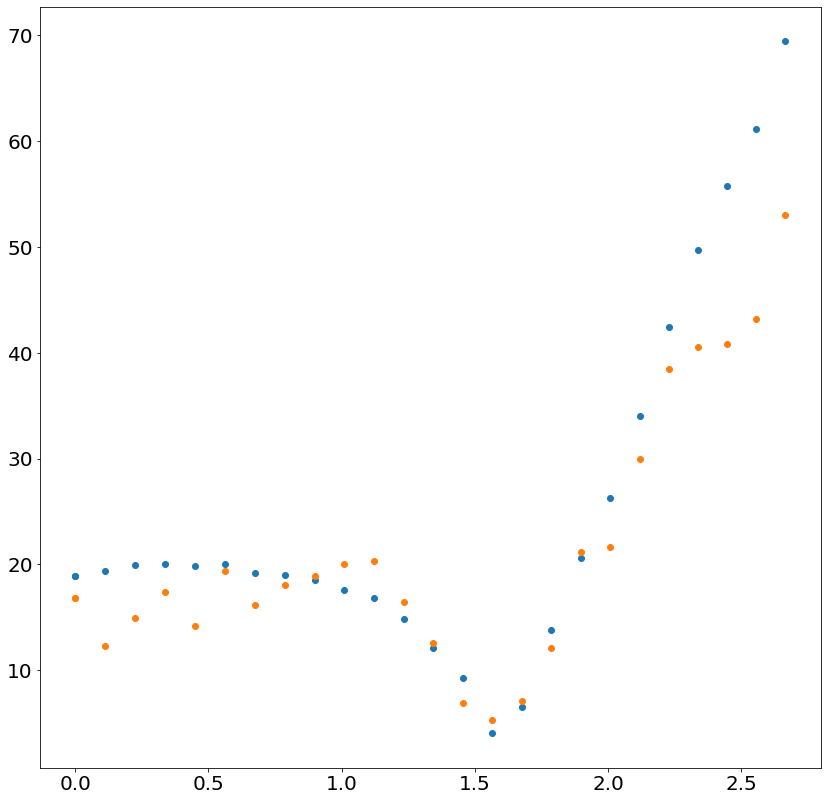

In [9]:
pl.figure(figsize=(14, 14))

pl.plot(Time, TruncR, marker='o', ls=' ')
pl.plot(Time, GasR, marker='o', ls=' ')

In [10]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

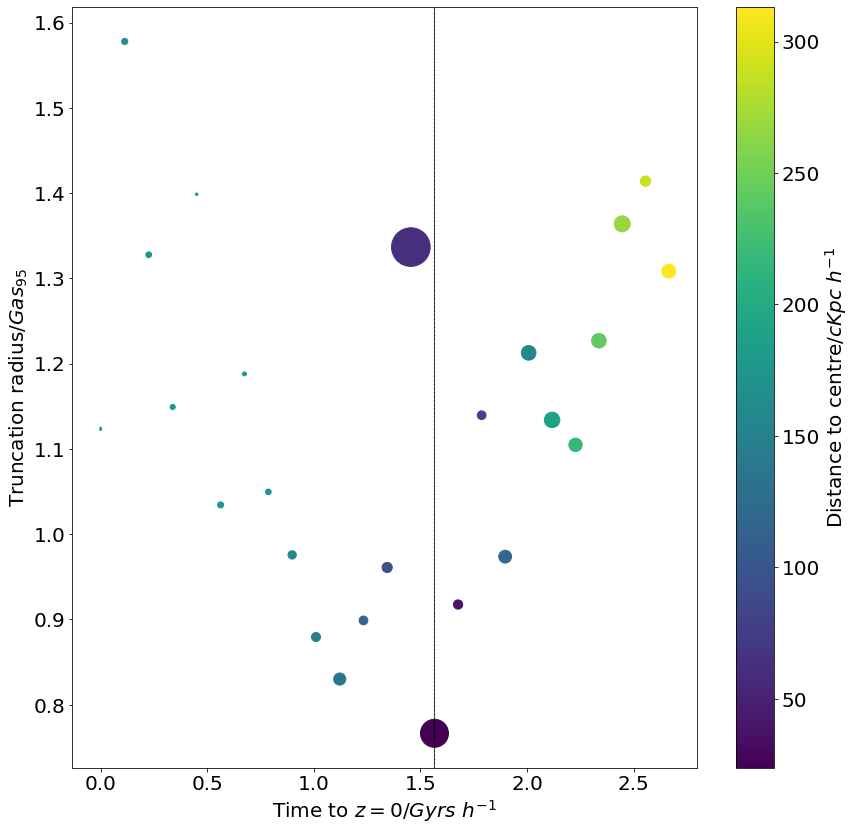

In [11]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [12]:
def getRadss(gal, cen):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    uniqueIDC = int(128*1e6+cen)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))

    Zlist, TruncR, GasR, dist = [], [], [], []

    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))

        OFFGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        OFFDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
        OFFStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        StarMass = np.sum(sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStars[0]:OFFStars[1]])
        GMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGas[0]:OFFGas[1]]
        GasMass = np.sum(GMass)
        DMMass = DMmass*(OFFDM[1]-OFFDM[0]) 


        SatMass = StarMass+GasMass+DMMass

        OFFGasC = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][iddC].astype('int')
        OFFDMC = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][iddC].astype('int')
        OFFStarsC = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][iddC].astype('int')


        CenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        CenG = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

        distB = np.sqrt(np.sum((CenG-CenP)**2.))

        StarPosC = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
        GasPosC = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGasC[0]:OFFGasC[1]]
        DMPosC = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][OFFDMC[0]:OFFDMC[1]]

        xSC, ySC, zSC = StarPosC[:,0] - CenP[0], StarPosC[:,1] - CenP[1], StarPosC[:,2] - CenP[2]
        rSC = np.sqrt(xSC**2.+ySC**2.+zSC**2.)
        iSCN = np.where(rSC<distB)

        xGC, yGC, zGC = GasPosC[:,0] - CenP[0], GasPosC[:,1] - CenP[1], GasPosC[:,2] - CenP[2]
        rGC = np.sqrt(xGC**2.+yGC**2.+zGC**2.)
        iGCN = np.where(rGC<distB)

        xDC, yDC, zDC = DMPosC[:,0] - CenP[0], DMPosC[:,1] - CenP[1], DMPosC[:,2] - CenP[2]
        rDC = np.sqrt(xDC**2.+yDC**2.+zDC**2.)
        iDCN = np.where(rDC<distB)

        SMassC = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][OFFStarsC[0]:OFFStarsC[1]]
        StarMassC = np.sum(SMassC[iSCN])
        GMassC = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][OFFGasC[0]:OFFGasC[1]]
        GasMassC = np.sum(GMassC[iGCN])
        DMMassC = DMmass*(iDCN[0].size) 

        CenMass = StarMassC+GasMassC+DMMassC
        
        rt = distB*(SatMass/(3.*CenMass))**(1./3.)

        GasPos = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][OFFGas[0]:OFFGas[1]]
        Gx, Gy, Gz = GasPos[:,0] - CenG[0], GasPos[:,1] - CenG[1], GasPos[:,2] - CenG[2]
        Rpart = np.sqrt(Gz**2.+Gy**2.+Gz**2.)
        
        Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][OFFGas[0]:OFFGas[1]]
        FeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
        iare = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))[0]
        FeHT = FeH[iare]
        med =np.median(FeHT)
        iraegood = np.where(FeHT>med)
        iare = iare[iraegood]
    
        Rpart, GMass = Rpart[iare], GMass[iare]

        GasMass = np.sum(GMass)
    #     r95gas = np.percentile(Rpart, 95) # I guess
        isort = np.argsort(Rpart)
        Rsort, Msort = Rpart[isort], GMass[isort]

        msum = 0.
        for i, ma in enumerate(Msort):
            msum += ma
            if msum>=.95*GasMass:
                break
        
        try:
            r95gas = Rsort[i]
        except:
            continue
            
        zn = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]

        Zlist.append(zn)
        TruncR.append(rt)
        GasR.append(r95gas)
        dist.append(distB)

    Zlist, TruncR, GasR, dist = np.array(Zlist), np.array(TruncR), np.array(GasR), np.array(dist)

    Time = Cosmo.lookback_time(Zlist).value

    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cen]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

    ii = np.where(dist<2*r200)

    Zlist, TruncR, GasR, dist, Time = Zlist[ii], TruncR[ii], GasR[ii], dist[ii], Time[ii]
    
    return Zlist, TruncR, GasR, dist, Time

In [13]:
gal, cen = 4339, 4337
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [14]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

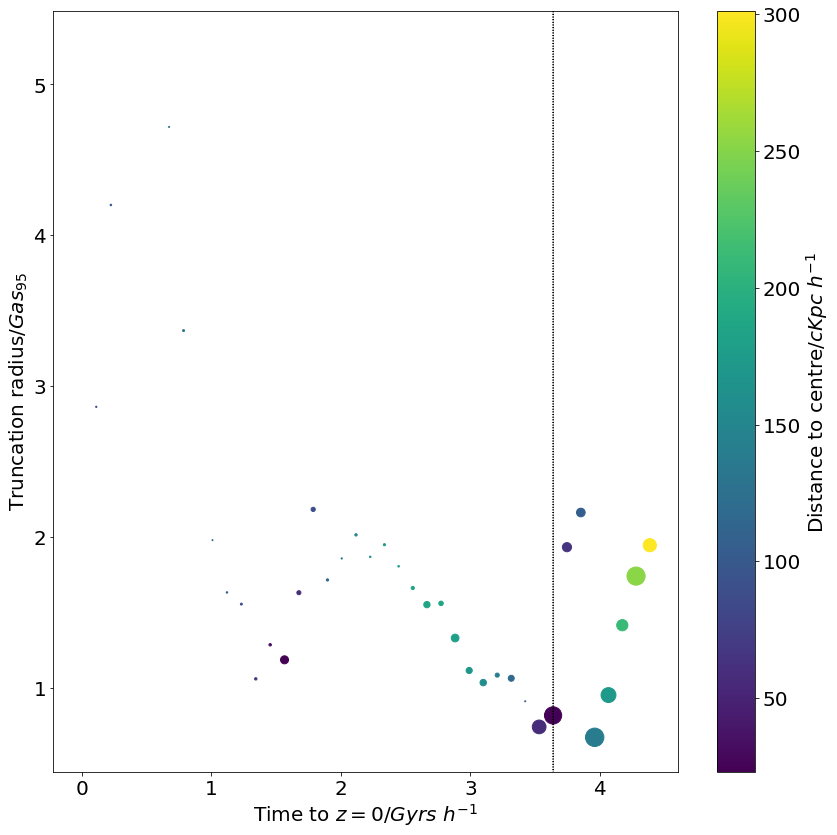

In [15]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [16]:
gal, cen = 4341, 4337
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

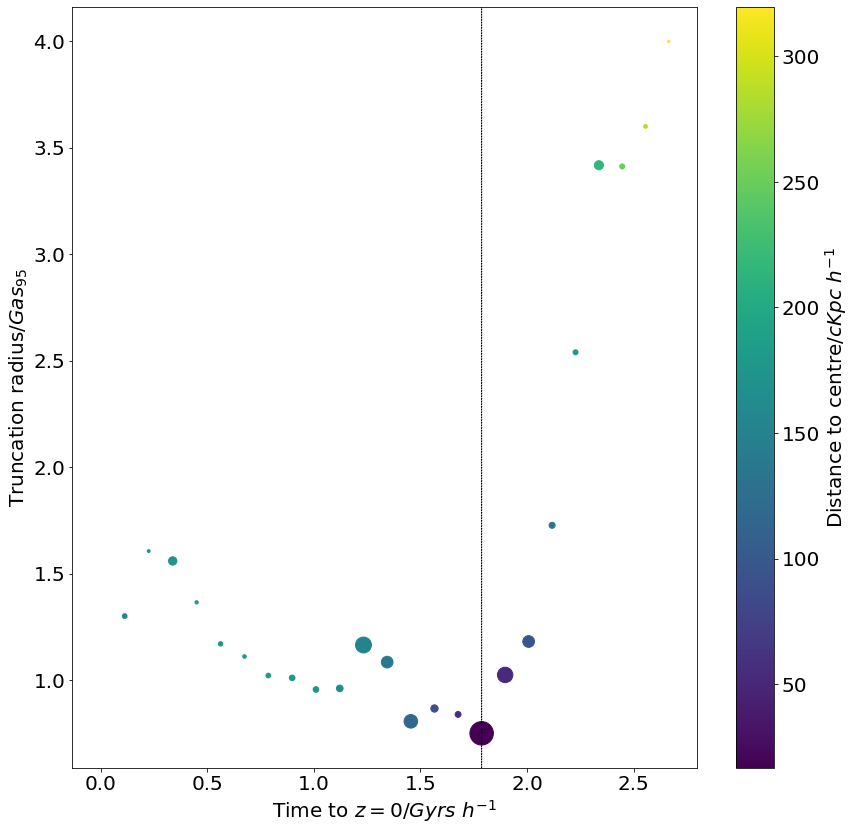

In [18]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [19]:
gal, cen = 4343, 4337
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [20]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

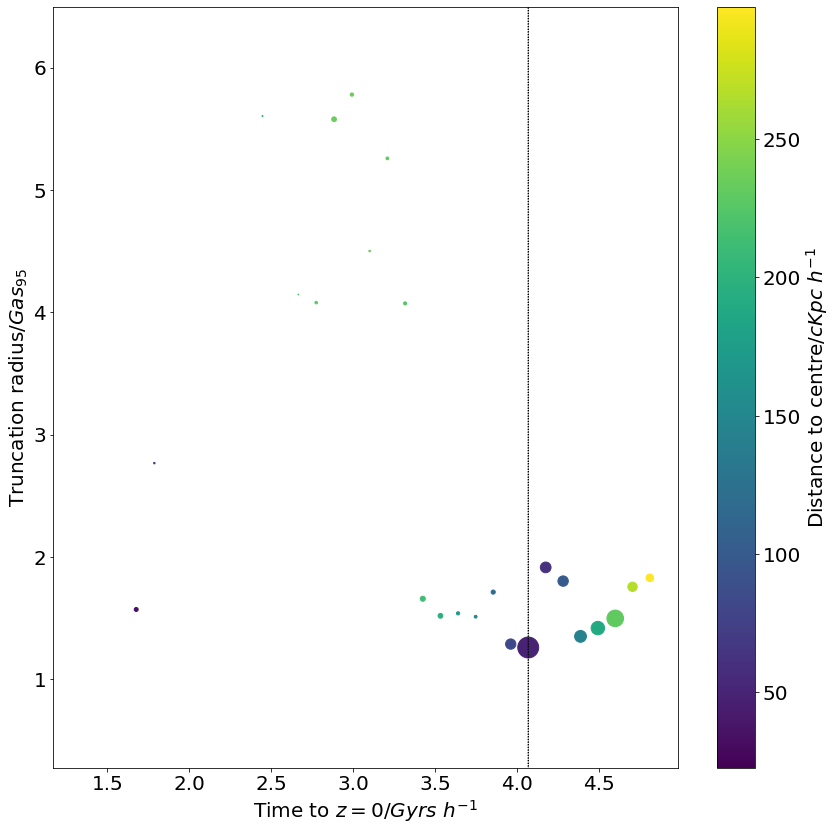

In [21]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [22]:
gal, cen = 4470, 4469
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [23]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

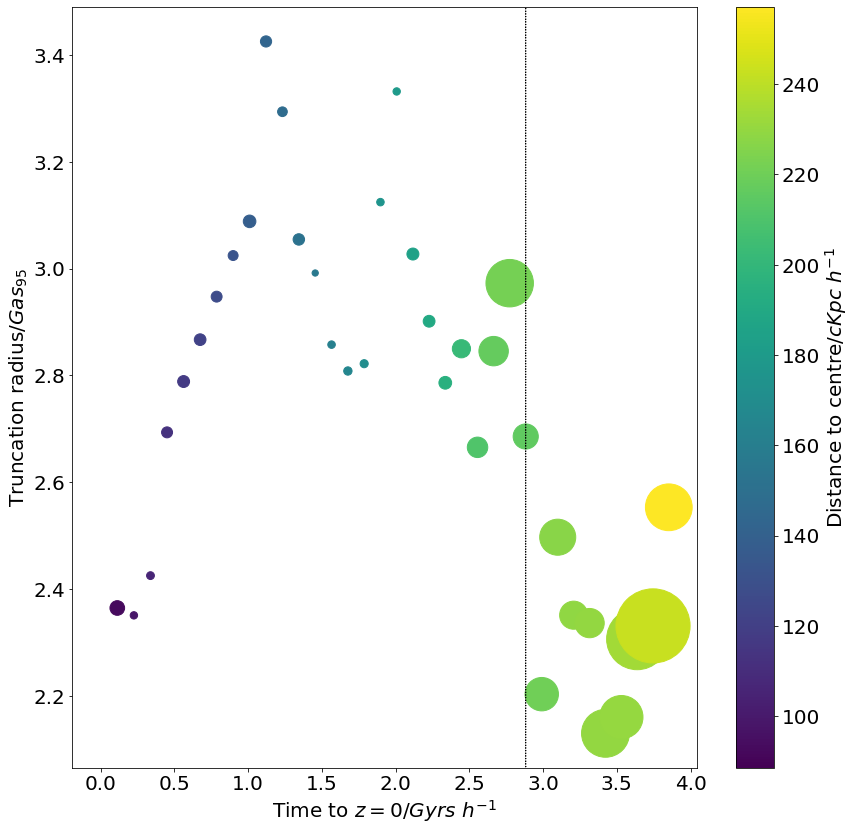

In [24]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [25]:
gal, cen = 4471, 4469
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [26]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

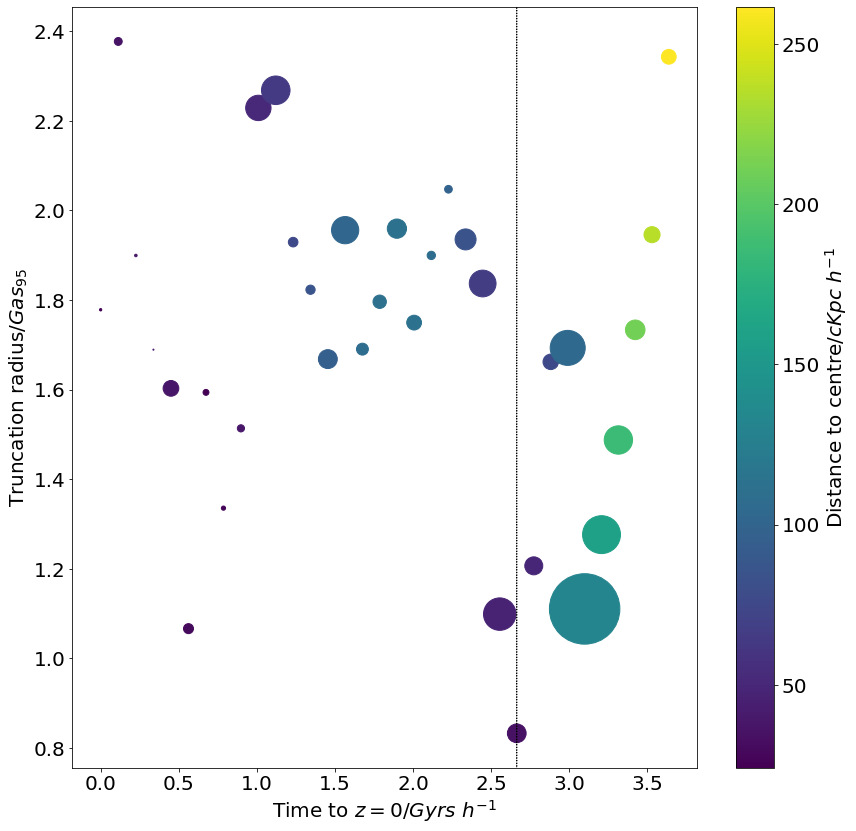

In [27]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [28]:
gal, cen = 4473, 4469
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [29]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

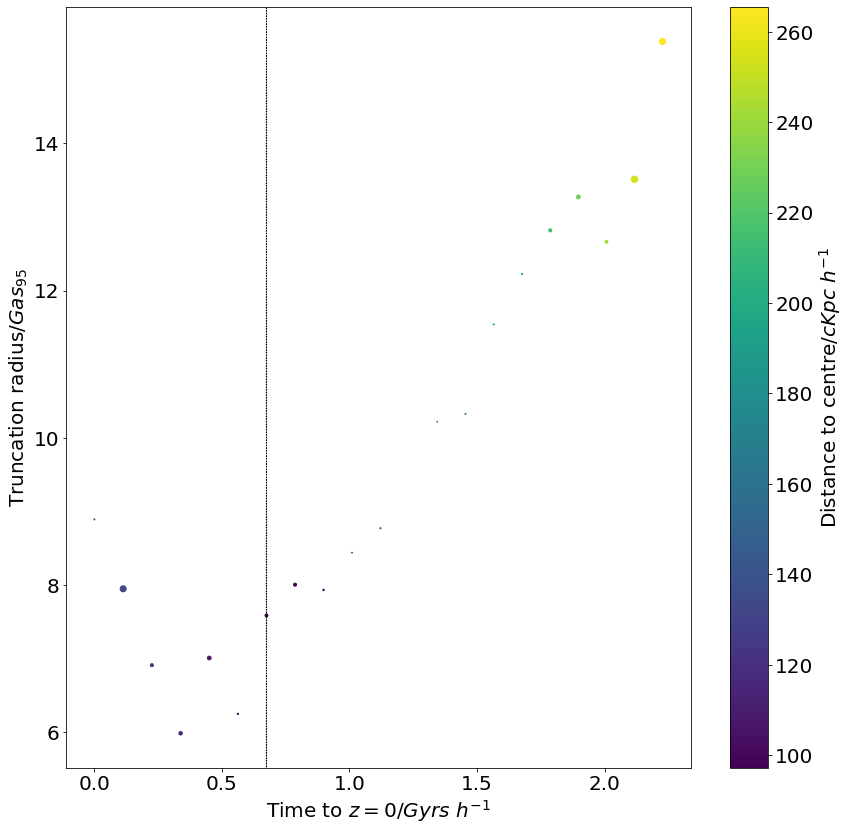

In [30]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')

In [31]:
gal, cen = 4474, 4469
Zlist, TruncR, GasR, dist, Time = getRadss(gal, cen)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log10


In [32]:
Ids, zorder, masslist = getAllLastP(gal)

MLost = []

for z in Zlist:
    ik = np.where(zorder==z)
    mtemp = np.sum(masslist[ik])
    MLost.append(mtemp)
    
MLost = np.array(MLost)

physD, Snap, mmr, firstsnap, Nturn, theID, theIDC = getperi(gal, cen)
zPeri = sim['SnapNumber_{}/Header/Redshift'.format(Snap)][()]
TPeri = Cosmo.lookback_time(zPeri).value

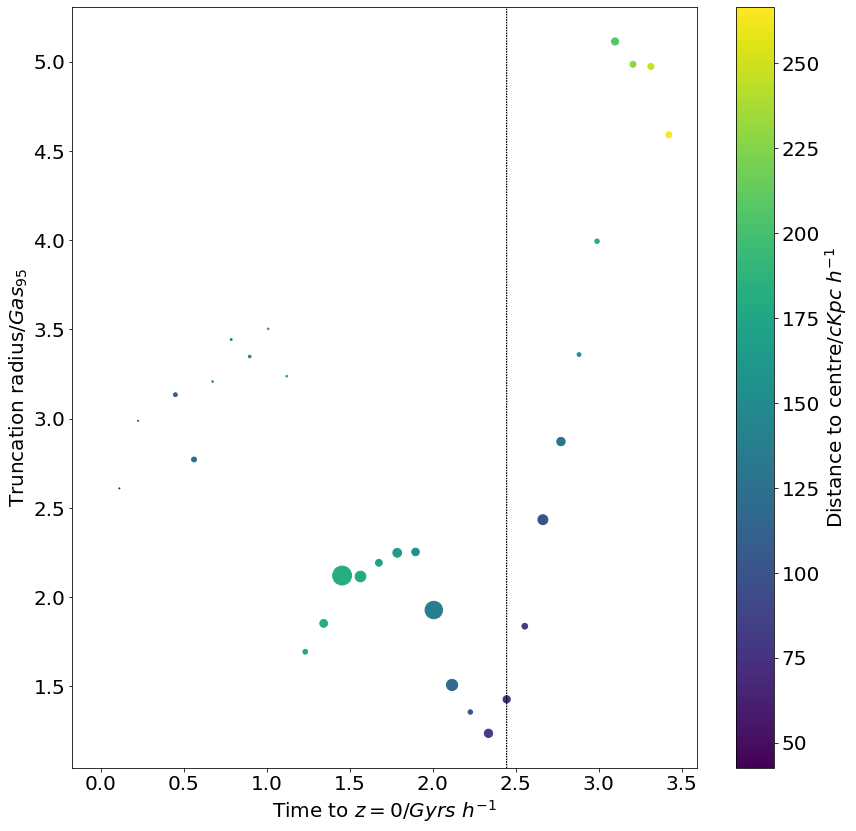

In [33]:
pl.figure(figsize=(14,14))

pl.scatter(Time, TruncR/GasR, marker='o', c=dist, s=MLost*5e4)

pl.ylabel('Truncation radius/$Gas_{95}$')
pl.xlabel('Time to $z=0/Gyrs\,\,h^{-1}$')

pl.arrow(TPeri, 0., 0., 1000., ls=':', color='black')

bar = pl.colorbar(label='Distance to centre$/cKpc\,\,h^{-1}$')